# 프로젝트 :  Segmentation map으로 도로 이미지 만들기
## 🎯 루브릭 평가
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

In [35]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. 데이터 준비하기

* [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

In [36]:
# !cd ~/aiffel/conditional_generation/data & wget https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip
# !cd ~/aiffel/conditional_generation/data && unzip cityscapes.zip

In [37]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes'
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')

In [38]:
print("number of train examples :", len(os.listdir(train_path)))
print("number of valid examples :", len(os.listdir(val_path)))

number of train examples : 1000
number of valid examples : 5


train 데이터를 시각화하여 확인해보자.

In [39]:
train_images_path = glob.glob(os.path.join(train_path,'*'))
train_images_path[:5]

['/aiffel/aiffel/conditional_generation/data/cityscapes/train/711.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/286.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/212.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/993.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/991.jpg']

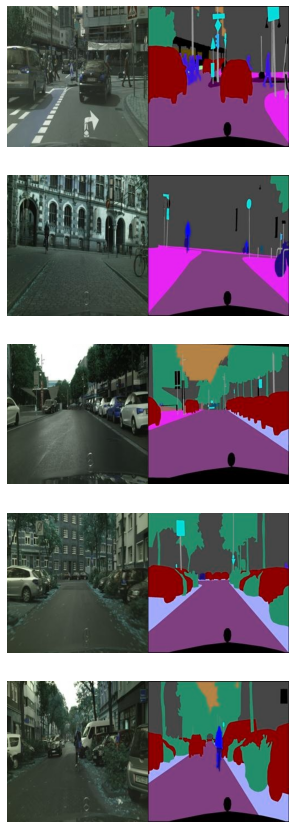

In [40]:
fig, axes =plt.subplots(nrows=5, figsize=(20,15))
for image_path, ax in zip(train_images_path, axes.flatten()):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ax.imshow(image)
    ax.axis("off")

하나의 이미지에 실제 도로 이미지와 segmentation된 결과가 합쳐져 있다.

In [41]:
image = cv2.imread(train_images_path[0], cv2.IMREAD_COLOR)
print(f'image size:{image.shape}')

image size:(256, 512, 3)


이미지 사이즈가 (256, 512, 3) 이므로 (256, 256, 3)으로 분할한다.

In [42]:
# 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 정규화를 다시 되돌린다.
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :] 
    real = tf.cast(real, tf.float32)
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32)
    return normalize(real), normalize(seg)

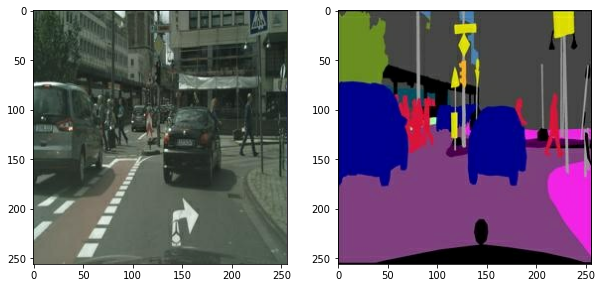

In [43]:
real, seg = load_img(train_images_path[0])

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(seg))

## augmentation 적용

In [44]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(real, seg):
    stacked = tf.concat([real, seg], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

##### apply_augmentation
* 랜덤으로 가장자리에 padding을 준다.
* 랜덤으로 crop된다.
* 랜덤으로 가로로 뒤집는다.
* 랜덤으로 세로로 뒤집는다.

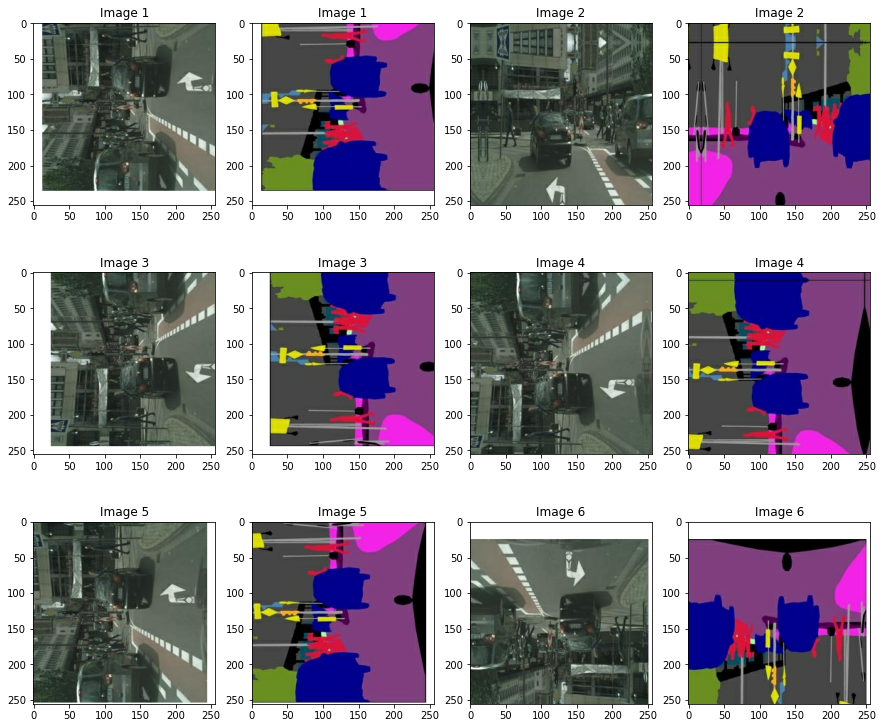

In [45]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_real, augmented_seg = apply_augmentation(real, seg)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    img_n += 1

## 2. 입력 파이프라인

In [46]:
from tensorflow import data

def get_train(img_path):
    real, seg = load_img(img_path)
    real, seg = apply_augmentation(real, seg)
    return real, seg

In [47]:
train_images = data.Dataset.list_files(train_path + "/*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

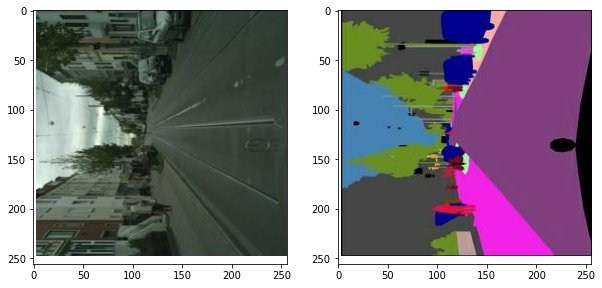

In [48]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
real, seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(real[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(seg[0].astype(np.uint8))

## 3. generator 구성
U-Net을 이용해 구성한다.

#### U-Net 구조
![image](https://user-images.githubusercontent.com/63278762/134177242-e98265df-b72d-4a1b-bf4c-35aa7f641571.png)

기본적인 블록

In [49]:
from tensorflow.keras import layers, Input, Model

In [50]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [51]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

U-net generator 구성

In [52]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [53]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_40 (EncodeBlock)   (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
encode_block_41 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_40[0][0]            
__________________________________________________________________________________________________
encode_block_42 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_41[0][0]            
____________________________________________________________________________________________

## 4. Discriminator 구성
Discriminator 기본 블록

In [54]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

입력에 따른 이미지의 크기가 맞는지 확인해본다.

In [55]:
inputs = Input((128,128,32))
# 1. 가로와 세로 각각 1씩 패딩되므로 (130,130,32) 크기를 가진다.
out = layers.ZeroPadding2D()(inputs)
# 2. OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 로 계산한다.
# stride=1, filtersize=4 (127,127,64)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
# 3. BatchNormalization과 LeakyReLU는 크기에 영향을 안줌.
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_106 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [56]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [57]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_54 (Concatenate)    (None, 256, 256, 6)  0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
disc_block_25 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_54[0][0]       

## 5. 모델 학습

Generator 및 Discriminator의 loss와 optimizer 구성

In [58]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [59]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

가중치를 1회 업데이트 하는 과정을 구현

In [60]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [61]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

history={'g_loss':[], 'l1_loss':[], 'd_loss':[]}
for epoch in range(1, EPOCHS+1):
    for i, (real, seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, real)
        history['g_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['d_loss'].append(d_loss)
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9304                     
L1_loss:0.3736                     
Discriminator_loss:1.2518

EPOCH[1] - STEP[20]                     
Generator_loss:0.9892                     
L1_loss:0.2225                     
Discriminator_loss:1.3122

EPOCH[1] - STEP[30]                     
Generator_loss:0.7078                     
L1_loss:0.2492                     
Discriminator_loss:1.3435

EPOCH[1] - STEP[40]                     
Generator_loss:0.7836                     
L1_loss:0.2094                     
Discriminator_loss:1.2847

EPOCH[1] - STEP[50]                     
Generator_loss:0.9795                     
L1_loss:0.1899                     
Discriminator_loss:1.2272

EPOCH[1] - STEP[60]                     
Generator_loss:1.0503                     
L1_loss:0.2076                     
Discriminator_loss:1.0985

EPOCH[1] - STEP[70]                     
Generator_loss:0.9415                     
L1_loss:0.1879                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.5663                     
L1_loss:0.1871                     
Discriminator_loss:0.8285

EPOCH[3] - STEP[80]                     
Generator_loss:1.5811                     
L1_loss:0.2115                     
Discriminator_loss:0.5056

EPOCH[3] - STEP[90]                     
Generator_loss:1.6263                     
L1_loss:0.1891                     
Discriminator_loss:0.9457

EPOCH[3] - STEP[100]                     
Generator_loss:1.1151                     
L1_loss:0.1844                     
Discriminator_loss:0.6355

EPOCH[3] - STEP[110]                     
Generator_loss:0.4789                     
L1_loss:0.2000                     
Discriminator_loss:1.4823

EPOCH[3] - STEP[120]                     
Generator_loss:1.7926                     
L1_loss:0.2192                     
Discriminator_loss:0.5631

EPOCH[3] - STEP[130]                     
Generator_loss:1.6813                     
L1_loss:0.1736                

EPOCH[5] - STEP[130]                     
Generator_loss:1.5570                     
L1_loss:0.1786                     
Discriminator_loss:2.0271

EPOCH[5] - STEP[140]                     
Generator_loss:1.7296                     
L1_loss:0.2162                     
Discriminator_loss:0.3245

EPOCH[5] - STEP[150]                     
Generator_loss:1.8392                     
L1_loss:0.1937                     
Discriminator_loss:0.4068

EPOCH[5] - STEP[160]                     
Generator_loss:1.8374                     
L1_loss:0.1809                     
Discriminator_loss:0.4528

EPOCH[5] - STEP[170]                     
Generator_loss:1.2558                     
L1_loss:0.1726                     
Discriminator_loss:0.7604

EPOCH[5] - STEP[180]                     
Generator_loss:0.8700                     
L1_loss:0.1943                     
Discriminator_loss:0.7415

EPOCH[5] - STEP[190]                     
Generator_loss:2.2625                     
L1_loss:0.1691             

EPOCH[7] - STEP[190]                     
Generator_loss:1.1273                     
L1_loss:0.1411                     
Discriminator_loss:0.8140

EPOCH[7] - STEP[200]                     
Generator_loss:1.3509                     
L1_loss:0.1851                     
Discriminator_loss:0.4083

EPOCH[7] - STEP[210]                     
Generator_loss:1.9050                     
L1_loss:0.2497                     
Discriminator_loss:0.3765

EPOCH[7] - STEP[220]                     
Generator_loss:1.7952                     
L1_loss:0.1868                     
Discriminator_loss:2.6618

EPOCH[7] - STEP[230]                     
Generator_loss:1.0763                     
L1_loss:0.1842                     
Discriminator_loss:1.0436

EPOCH[7] - STEP[240]                     
Generator_loss:0.5637                     
L1_loss:0.1850                     
Discriminator_loss:2.1850

EPOCH[7] - STEP[250]                     
Generator_loss:0.4076                     
L1_loss:0.1623             

EPOCH[9] - STEP[250]                     
Generator_loss:1.0281                     
L1_loss:0.1564                     
Discriminator_loss:2.4007

EPOCH[10] - STEP[10]                     
Generator_loss:1.0322                     
L1_loss:0.2115                     
Discriminator_loss:0.5085

EPOCH[10] - STEP[20]                     
Generator_loss:1.1354                     
L1_loss:0.2034                     
Discriminator_loss:0.5299

EPOCH[10] - STEP[30]                     
Generator_loss:2.3257                     
L1_loss:0.1786                     
Discriminator_loss:0.5305

EPOCH[10] - STEP[40]                     
Generator_loss:0.3497                     
L1_loss:0.1547                     
Discriminator_loss:1.7327

EPOCH[10] - STEP[50]                     
Generator_loss:0.8449                     
L1_loss:0.2029                     
Discriminator_loss:0.7838

EPOCH[10] - STEP[60]                     
Generator_loss:2.2337                     
L1_loss:0.1697             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9538                     
L1_loss:0.1695                     
Discriminator_loss:0.6822

EPOCH[12] - STEP[70]                     
Generator_loss:1.6766                     
L1_loss:0.1925                     
Discriminator_loss:0.3752

EPOCH[12] - STEP[80]                     
Generator_loss:3.6891                     
L1_loss:0.1651                     
Discriminator_loss:2.8069

EPOCH[12] - STEP[90]                     
Generator_loss:0.4056                     
L1_loss:0.2254                     
Discriminator_loss:1.1814

EPOCH[12] - STEP[100]                     
Generator_loss:1.8054                     
L1_loss:0.1504                     
Discriminator_loss:1.0102

EPOCH[12] - STEP[110]                     
Generator_loss:0.9777                     
L1_loss:0.1592                     
Discriminator_loss:1.0442

EPOCH[12] - STEP[120]                     
Generator_loss:1.6728                     
L1_loss:0.1866          

EPOCH[14] - STEP[120]                     
Generator_loss:1.3433                     
L1_loss:0.1687                     
Discriminator_loss:1.1261

EPOCH[14] - STEP[130]                     
Generator_loss:1.1476                     
L1_loss:0.1888                     
Discriminator_loss:0.7597

EPOCH[14] - STEP[140]                     
Generator_loss:1.4070                     
L1_loss:0.1714                     
Discriminator_loss:1.3920

EPOCH[14] - STEP[150]                     
Generator_loss:1.4626                     
L1_loss:0.1917                     
Discriminator_loss:0.8297

EPOCH[14] - STEP[160]                     
Generator_loss:1.9562                     
L1_loss:0.1664                     
Discriminator_loss:1.8389

EPOCH[14] - STEP[170]                     
Generator_loss:0.8102                     
L1_loss:0.1754                     
Discriminator_loss:1.3510

EPOCH[14] - STEP[180]                     
Generator_loss:0.5922                     
L1_loss:0.1639      

EPOCH[16] - STEP[180]                     
Generator_loss:2.6454                     
L1_loss:0.2013                     
Discriminator_loss:0.4684

EPOCH[16] - STEP[190]                     
Generator_loss:2.3573                     
L1_loss:0.1847                     
Discriminator_loss:0.7601

EPOCH[16] - STEP[200]                     
Generator_loss:1.0555                     
L1_loss:0.2069                     
Discriminator_loss:1.2846

EPOCH[16] - STEP[210]                     
Generator_loss:2.2379                     
L1_loss:0.1696                     
Discriminator_loss:1.4063

EPOCH[16] - STEP[220]                     
Generator_loss:2.6507                     
L1_loss:0.1745                     
Discriminator_loss:0.3683

EPOCH[16] - STEP[230]                     
Generator_loss:2.6527                     
L1_loss:0.1436                     
Discriminator_loss:1.7660

EPOCH[16] - STEP[240]                     
Generator_loss:0.4245                     
L1_loss:0.2076      

EPOCH[18] - STEP[240]                     
Generator_loss:1.9662                     
L1_loss:0.1774                     
Discriminator_loss:0.4186

EPOCH[18] - STEP[250]                     
Generator_loss:2.7517                     
L1_loss:0.1722                     
Discriminator_loss:0.9438

EPOCH[19] - STEP[10]                     
Generator_loss:0.6590                     
L1_loss:0.1514                     
Discriminator_loss:1.3768

EPOCH[19] - STEP[20]                     
Generator_loss:1.7477                     
L1_loss:0.1839                     
Discriminator_loss:1.6771

EPOCH[19] - STEP[30]                     
Generator_loss:2.4702                     
L1_loss:0.1764                     
Discriminator_loss:1.2211

EPOCH[19] - STEP[40]                     
Generator_loss:0.6911                     
L1_loss:0.1785                     
Discriminator_loss:1.1529

EPOCH[19] - STEP[50]                     
Generator_loss:3.0261                     
L1_loss:0.2168           

## 6. 모델 테스트

In [62]:
valid_images_path = glob.glob(os.path.join(val_path,'*'))
valid_images_path

['/aiffel/aiffel/conditional_generation/data/cityscapes/val/5.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/val/1.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/val/2.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/val/4.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/val/3.jpg']

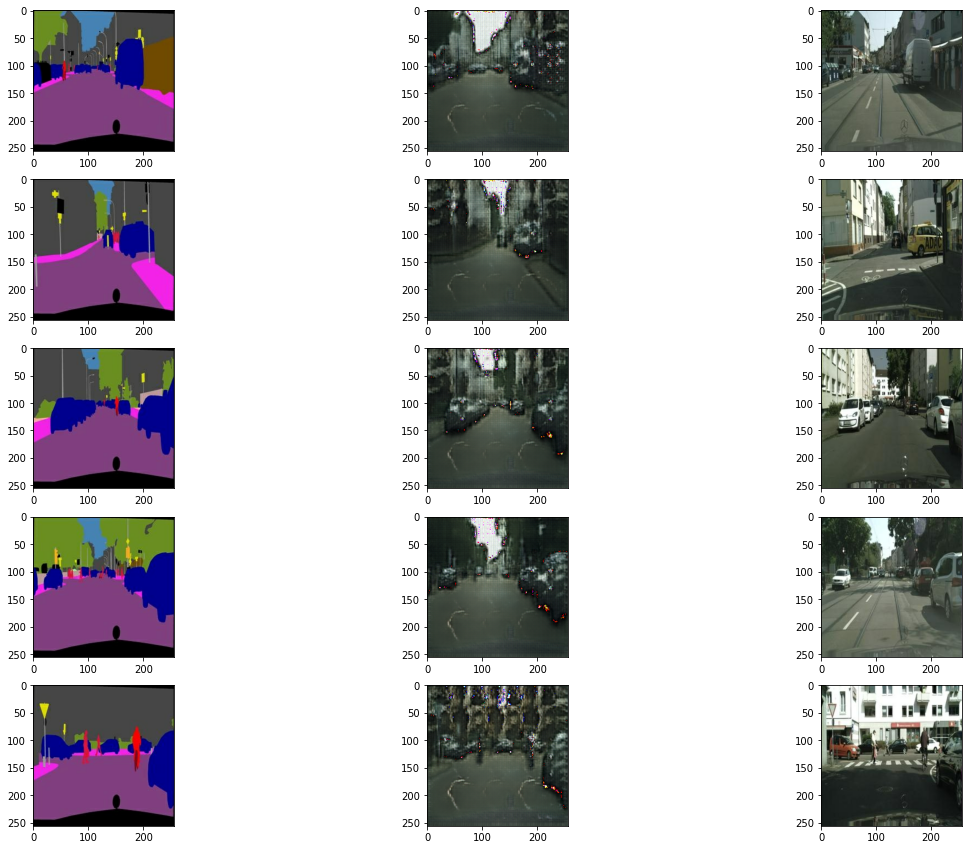

In [63]:
fig, axs=plt.subplots(ncols=3, nrows=len(valid_images_path), figsize=(20,15))

for idx, image_path in enumerate(valid_images_path):
    real, seg = load_img(image_path)

    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    
    axs[idx][0].imshow(denormalize(seg))
    axs[idx][1].imshow(pred[0])
    axs[idx][2].imshow(denormalize(real))

도로나 나무를 어느정도 만들지는 듯 하지만 마지막 결과물은 건물부분이 제대로 그려지지 않앗다. segmentation이 제대로 만들어지지 않아서 그런 것인 듯 하다.

# 회고

## 아쉬운 점
* 시간이 더 많았으면 에폭을 더 주고 충분히 훈련을 시키고 테스트를 해봤을 텐데 20에폭밖에 안줘서 결과가 만족스럽지 않은 것 같다.

## 느낀점
* 저번에 배웠던 GAN에서 조금 더 발전된 형태인 cGAN에 대해서 배웠다. 
* U-Net 구성하는 법을 배웠다. 

# Reference
* https://velog.io/@guide333/U-Net-%EC%A0%95%EB%A6%AC
* https://runebook.dev/ko/docs/tensorflow/data/dataset